# Zero-shot reference mapping tutorial with scGPT


This tutorial covers the zero-shot reference mapping with scGPT. This workflow achieves accurate and fast reference mapping for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT.

We will use COVID-19 dataset to demonstrate the zero-shot reference mapping. You can download the processed reference and query datasets from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). The COVID-19 dataset is derived from the work by [Lotfollahi et al](https://www.nature.com/articles/s41587-021-01001-7), which contains 18 distinct batches and diverse samples from lung tissues. The reference dataset consists of 15,997 cells and the query dataset contains 4,003 cells. You may place the dataset under data directory in the outer level.

Particularly, we use the scGPT_human model to provide embeddings out of the box. You may download it from here.

The zero-shot reference mapping workflow is as follows:

1. Load and pre-process the dataset

2. Generate scGPT embeddings for each cell in reference and query datasets

3. Transfer the annotations from reference to query dataset

At the appendix of this tutorial, we will also showcase the zero-shot reference mapping on Lung dataset. You can find the dataset here.

We use a similarity-based method for transferring the annotation, which involves comparing the similarity between the query cell embedding and the reference cell embeddings. We use FAISS to perform the similarity search.

Open In Colab

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import mode
import scanpy as sc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys
import warnings

sys.path.insert(0, "../")
import scgpt as scg
import gdown
from pathlib import Path
# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [30]:
data_dir_test = Path("/home/s5srinivasan/covid-annotation-scgpt/data")
anndataTest = sc.read(data_dir_test/"covidData.h5ad")

In [34]:
from scipy.sparse import issparse

print(issparse(anndataTest.X))
print(anndataTest.obs.memory_usage(deep=True).sum() / 1e6, "MB")  # Cell metadata
print(anndataTest.var.memory_usage(deep=True).sum() / 1e6, "MB")  # Cell metadata


True
59.252341 MB
2.287024 MB


## Reference mapping using a customized reference dataset


In [4]:
project_dir = Path("/home/s5srinivasan/covid-annotation-scgpt")
model_dir = Path(project_dir/"save/nikolic100Full")
reference_data = sc.read_h5ad(project_dir/"data/reference-mapping/annotation-covid/batch_covid_subsampled_train.h5ad")
query_data = sc.read_h5ad(project_dir/"data/reference-mapping/annotation-covid/batch_covid_subsampled_test.h5ad")
cell_type_key = "celltype"
gene_col = "index"

In [3]:
query_data

AnnData object with n_obs × n_vars = 4003 × 1200
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', 'str_batch', 'batch_id'
    var: 'n_cells-0', 'n_cells-0-0-1', 'gene_ids-1-0-1', 'feature_types-1-0-1', 'genome-1-0-1', 'gene_name', 'n_counts', 'highly_variable', 'highly_variable_rank', 

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 250/250 [00:10<00:00, 22.87it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


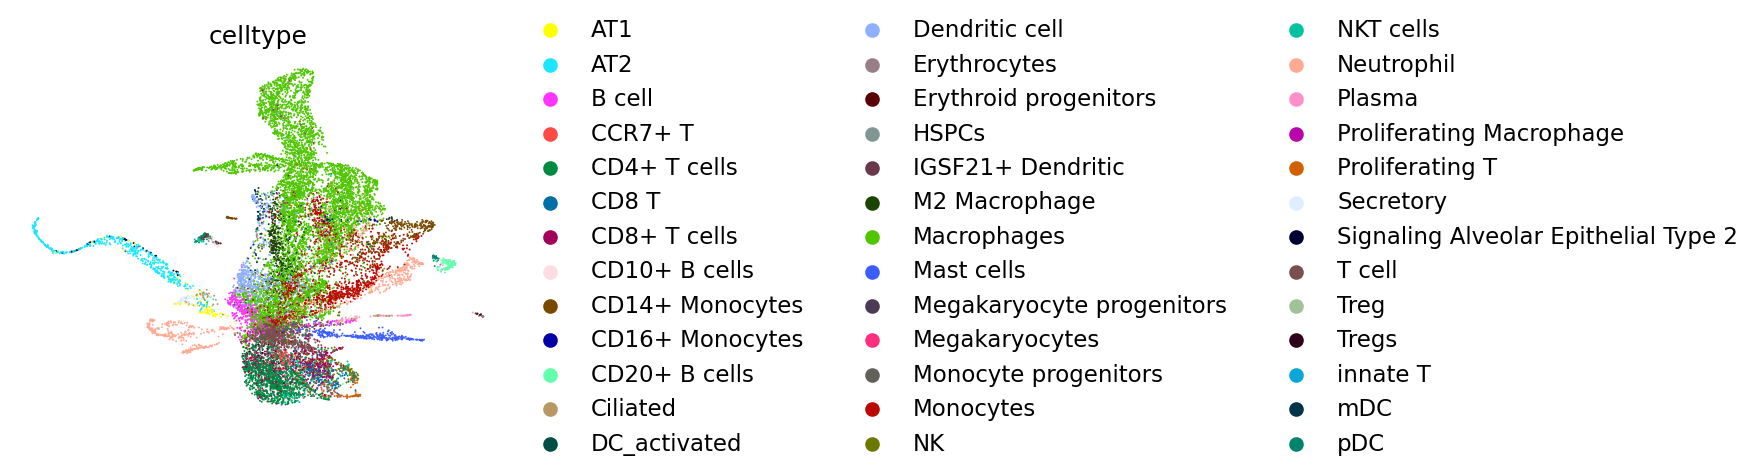

In [7]:
ref_embed_adata = scg.tasks.embed_data(
    reference_data,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
)

# # running on cpu, not recommended since it is slow
# ref_embed_adata = scg.tasks.embed_data(
#     adata,
#     model_dir,
#     gene_col=gene_col,
#     obs_to_save=cell_type_key,
#     batch_size=64,
#     device="cpu",
#     use_fast_transformer=False,
#     return_new_adata=True,
# )

sc.pp.neighbors(ref_embed_adata, use_rep="X")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

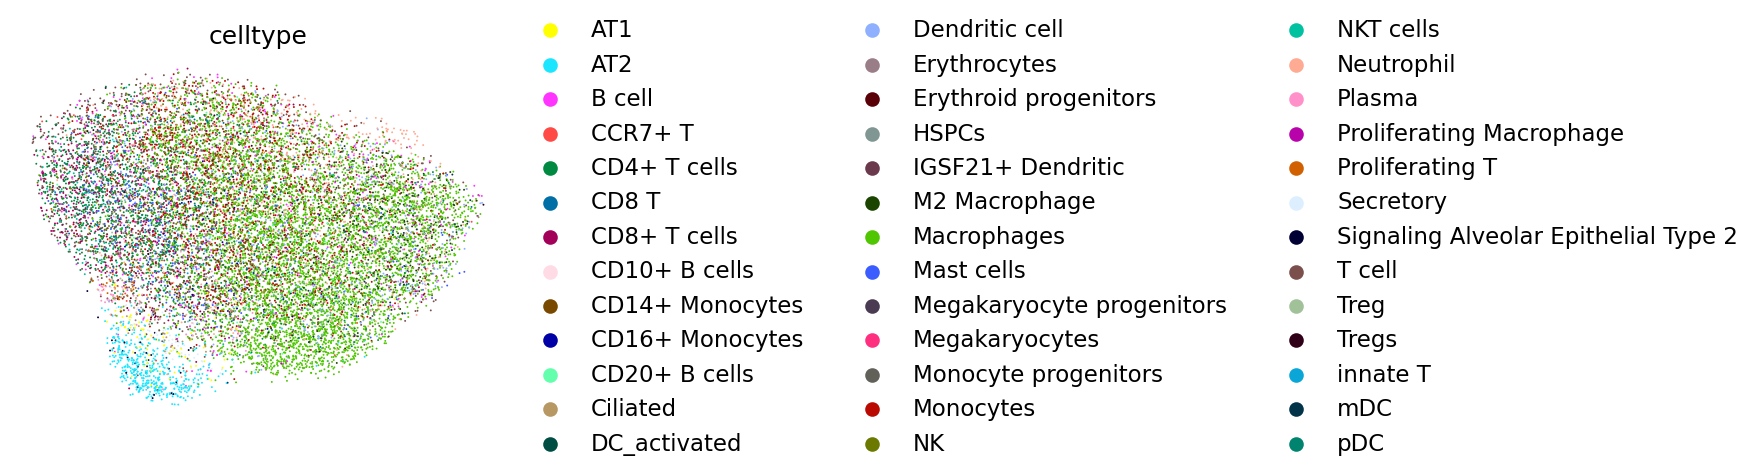

In [8]:
sc.pp.neighbors(ref_embed_adata, use_rep="X_scGPT")
sc.tl.umap(ref_embed_adata)
sc.pl.umap(ref_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 63/63 [00:03<00:00, 16.00it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


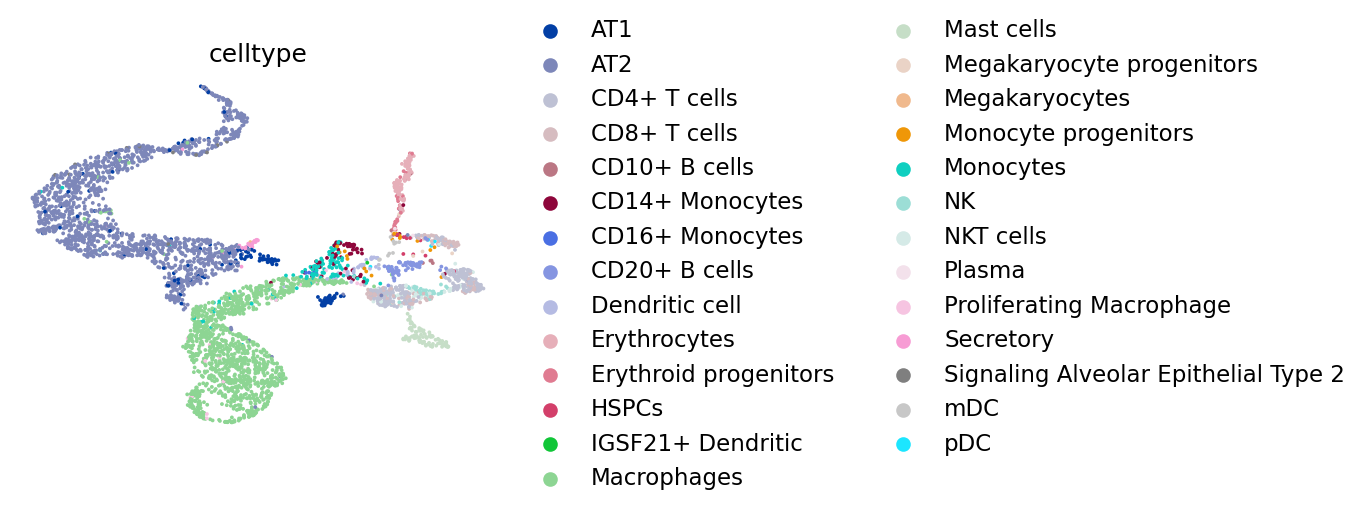

In [9]:
query_embed_adata = scg.tasks.embed_data(
    query_data,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

sc.pp.neighbors(query_embed_adata, use_rep="X")
sc.tl.umap(query_embed_adata)
sc.pl.umap(query_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

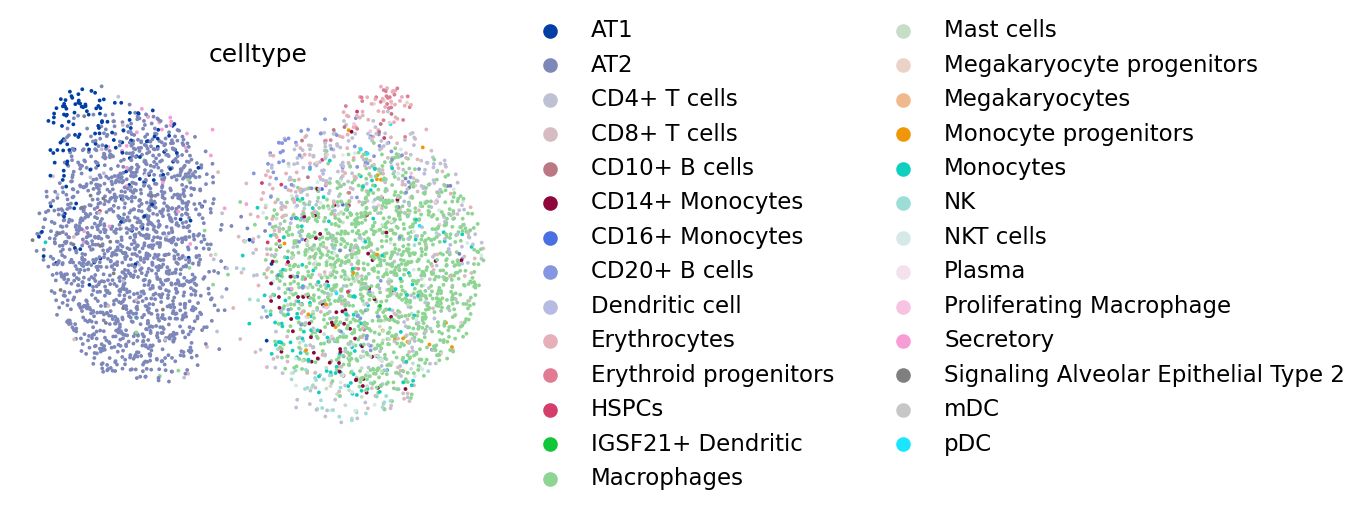

In [10]:
sc.pp.neighbors(query_embed_adata, use_rep="X_scGPT")
sc.tl.umap(query_embed_adata)
sc.pl.umap(query_embed_adata, color=cell_type_key, frameon=False, wspace=0.4)

In [11]:
ref_embed_adata

AnnData object with n_obs × n_vars = 15997 × 1173
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', 'str_batch', 'batch_id'
    var: 'n_cells-0', 'n_cells-0-0-1', 'gene_ids-1-0-1', 'feature_types-1-0-1', 'genome-1-0-1', 'gene_name', 'n_counts', 'highly_variable', 'highly_variable_rank',

In [12]:
# concatenate the two datasets
adata_concat = query_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(query_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(query_embed_adata)] = "To be predicted"

/tmp/ipykernel_143812/3150963998.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = query_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
/tmp/ipykernel_143812/3150963998.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single st

## Visualize the embeddings
We visualize the embeddings from query and reference datasets using UMAP


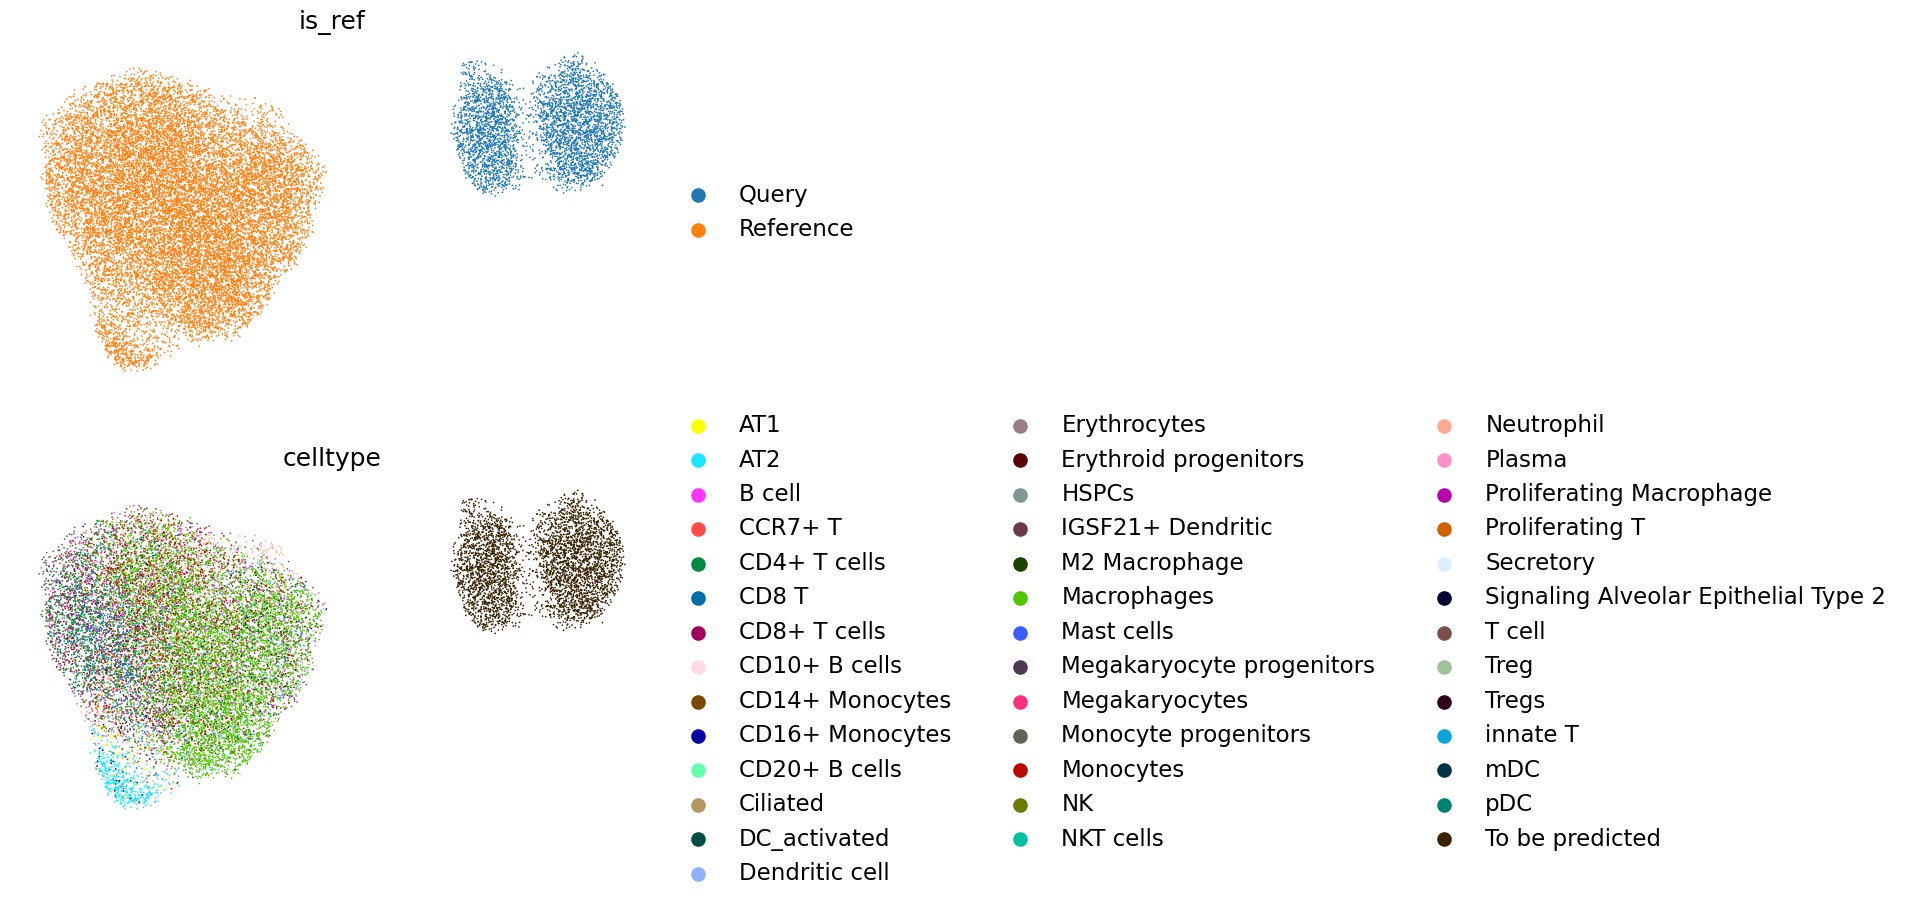

In [13]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## Reference mapping and transfer the annotations
We run the reference mapping using cell-level majority voting. You may adjust the k parameter to control the number of nearest neighbors to consider for voting.

In [14]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [15]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
query_cell_embeddings = query_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors


index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(query_cell_embeddings, k)

idx_list=[i for i in range(query_cell_embeddings.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(query_cell_embeddings[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = query_data.obs[cell_type_key].to_numpy()

/tmp/ipykernel_143812/3276322237.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/tmp/ipykernel_143812/3276322237.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/tmp/ipykernel_143812/3276322237.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_c

## Evaluate performance

In [16]:
from sklearn import metrics 
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'macro_f1': 0.0}

/tmp/ipykernel_143812/3308124233.py:5: RuntimeWarning: invalid value encountered in divide
  matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]


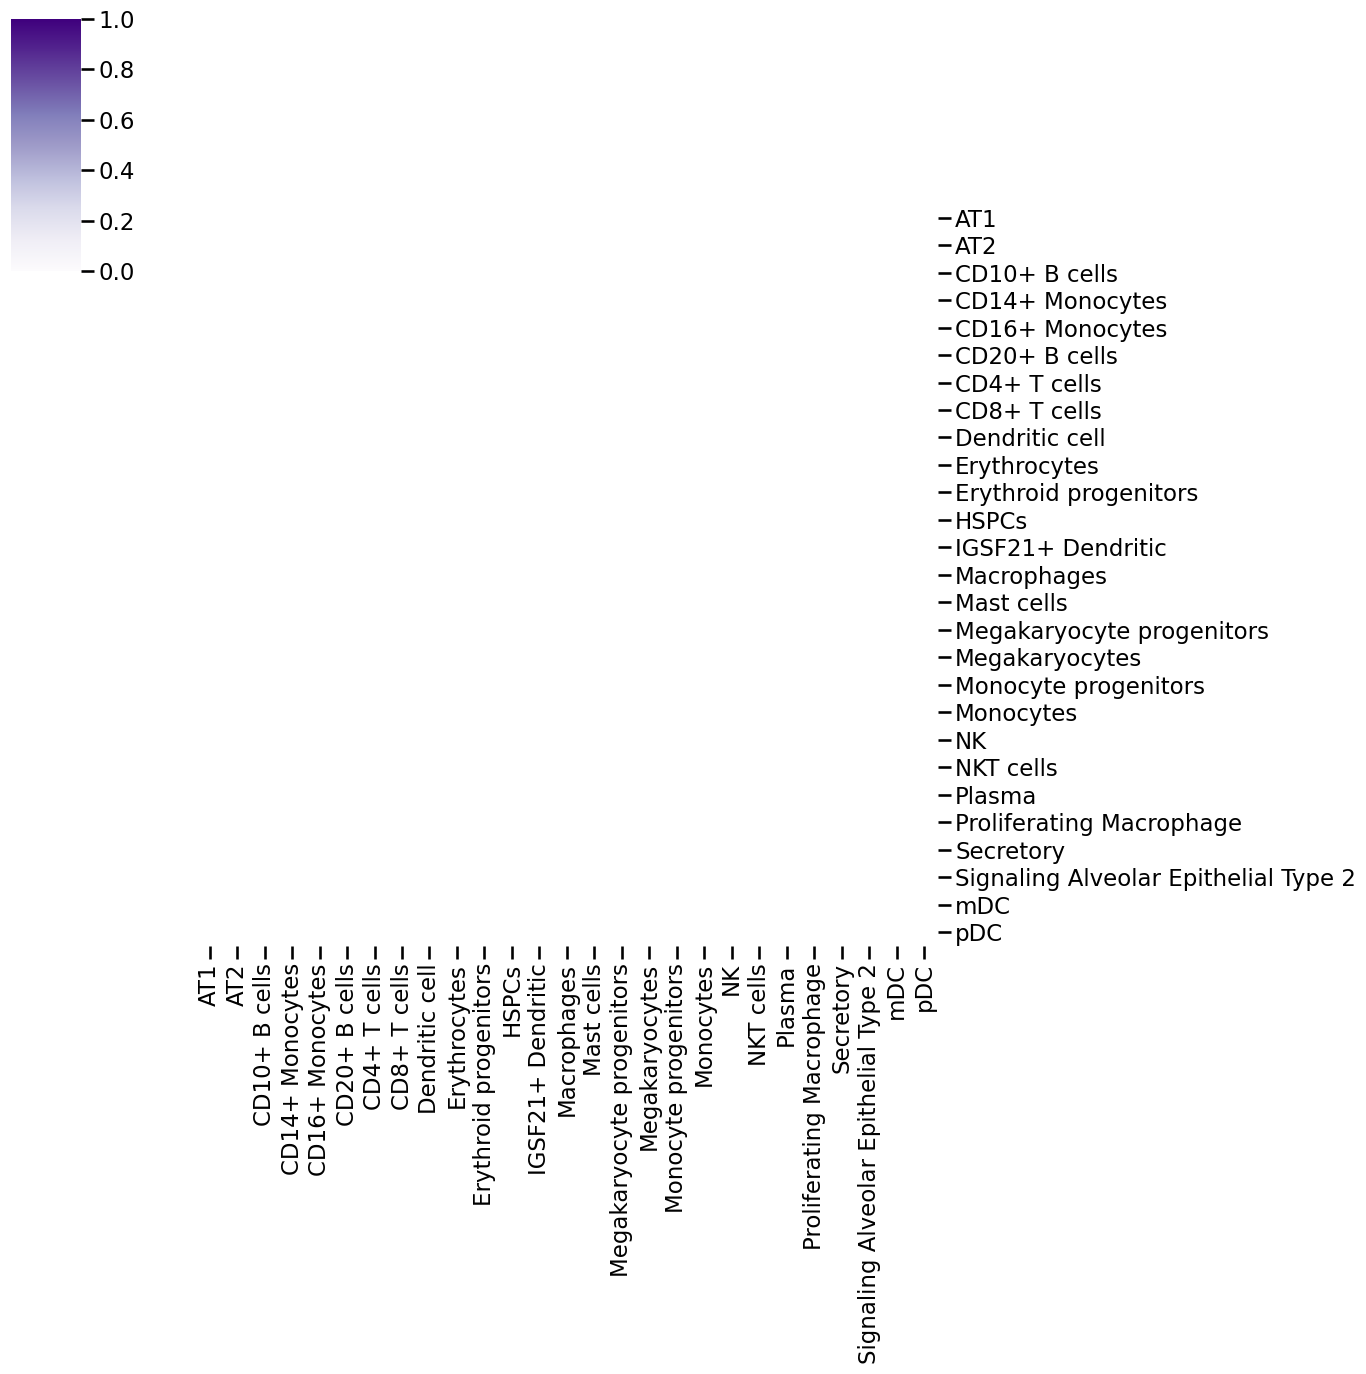

In [17]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))

# Finetuned model on Mukund et al - Reference mapping

In [88]:
project_dir = Path("/home/s5srinivasan/covid-annotation-scgpt")
model_dir = Path(project_dir/"save/randomModel")
ref_data_rdModel = sc.read_h5ad(project_dir/"data/reference-mapping/annotation-covid/batch_covid_subsampled_train.h5ad")
query_data_rdModel = sc.read_h5ad(project_dir/"data/reference-mapping/annotation-covid/batch_covid_subsampled_test.h5ad")
cell_type_key = "celltype"
gene_col = "index"

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 250/250 [00:11<00:00, 21.39it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


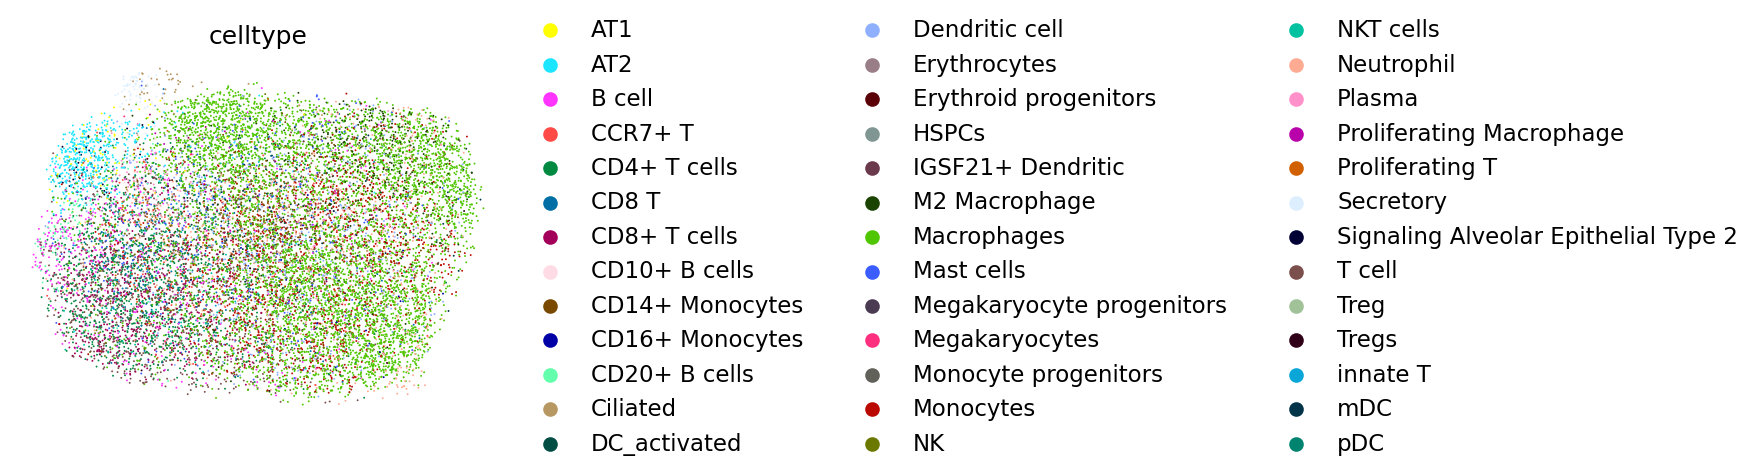

In [89]:
ref_embed_adata_rdModel = scg.tasks.embed_data(
    ref_data_rdModel,
    model_dir,
    gene_col=gene_col,
    obs_to_save=cell_type_key,  # optional arg, only for saving metainfo
    batch_size=64,
)

sc.pp.neighbors(ref_embed_adata_rdModel, use_rep="X_scGPT")
sc.tl.umap(ref_embed_adata_rdModel)
sc.pl.umap(ref_embed_adata_rdModel, color=cell_type_key, frameon=False, wspace=0.4)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 63/63 [00:04<00:00, 14.57it/s]
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


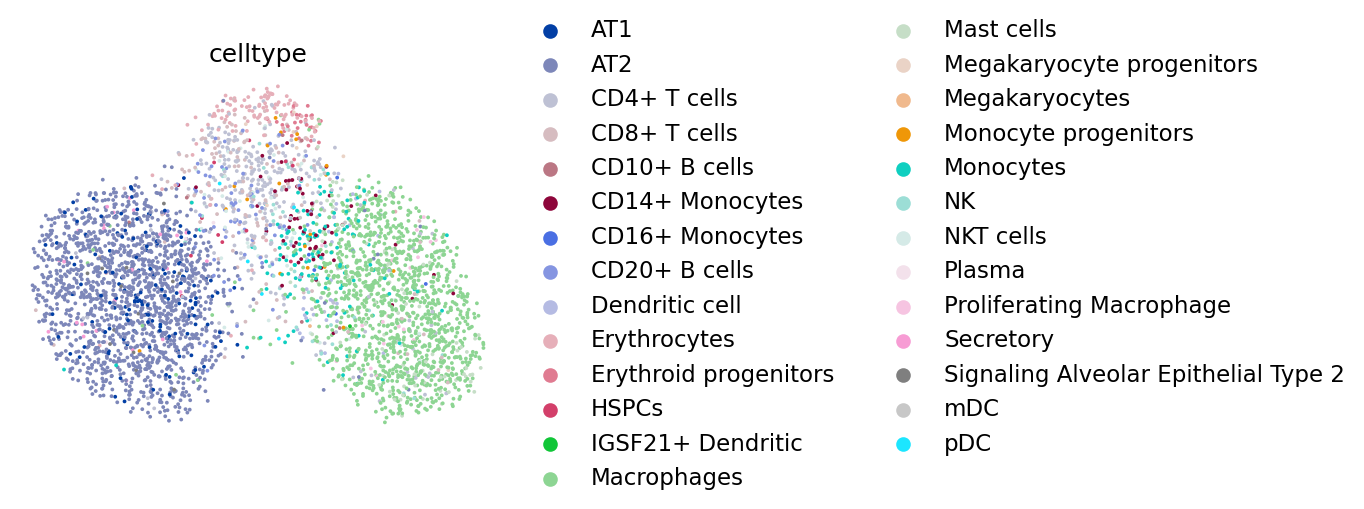

In [90]:
query_embed_adata_rdModel = scg.tasks.embed_data(
    query_data_rdModel,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

sc.pp.neighbors(query_embed_adata_rdModel, use_rep="X_scGPT")
sc.tl.umap(query_embed_adata_rdModel)
sc.pl.umap(query_embed_adata_rdModel, color=cell_type_key, frameon=False, wspace=0.4)

In [74]:
# concatenate the two datasets
adata_concat_rdModel = query_embed_adata_rdModel.concatenate(ref_embed_adata_rdModel, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat_rdModel.obs["is_ref"] = ["Query"] * len(query_embed_adata_rdModel) + ["Reference"] * len(
    ref_embed_adata_rdModel
)
adata_concat_rdModel.obs["is_ref"] = adata_concat_rdModel.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat_rdModel.obs[cell_type_key] = adata_concat_rdModel.obs[cell_type_key].astype("category")
adata_concat_rdModel.obs[cell_type_key] = adata_concat_rdModel.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat_rdModel.obs[cell_type_key][: len(query_embed_adata_rdModel)] = "To be predicted"

/tmp/ipykernel_760742/3895308944.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat_rdModel = query_embed_adata_rdModel.concatenate(ref_embed_adata_rdModel, batch_key="dataset")
/tmp/ipykernel_760742/3895308944.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the a

In [81]:
adata_concat_rdModel

AnnData object with n_obs × n_vars = 20000 × 1173
    obs: 'age', 'age_range', 'anatomical_region', 'anatomical_region_detailed', 'batch', 'dataset', 'disease', 'donor', 'ethnicity', 'ethnicity_mixed', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'pack_years', 'sample', 'sample_alias', 'sample_type', 'sampling_method', 'sex', 'smoking', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'subject_type', 'study', 'study2', 'celltype', 'condition', 'cellnames', 'cluster', 'stage', 'ID', 'sample_new', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'tissue', 'str_batch', 'batch_id', 'is_ref'
    var: 'gene_name', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'index',

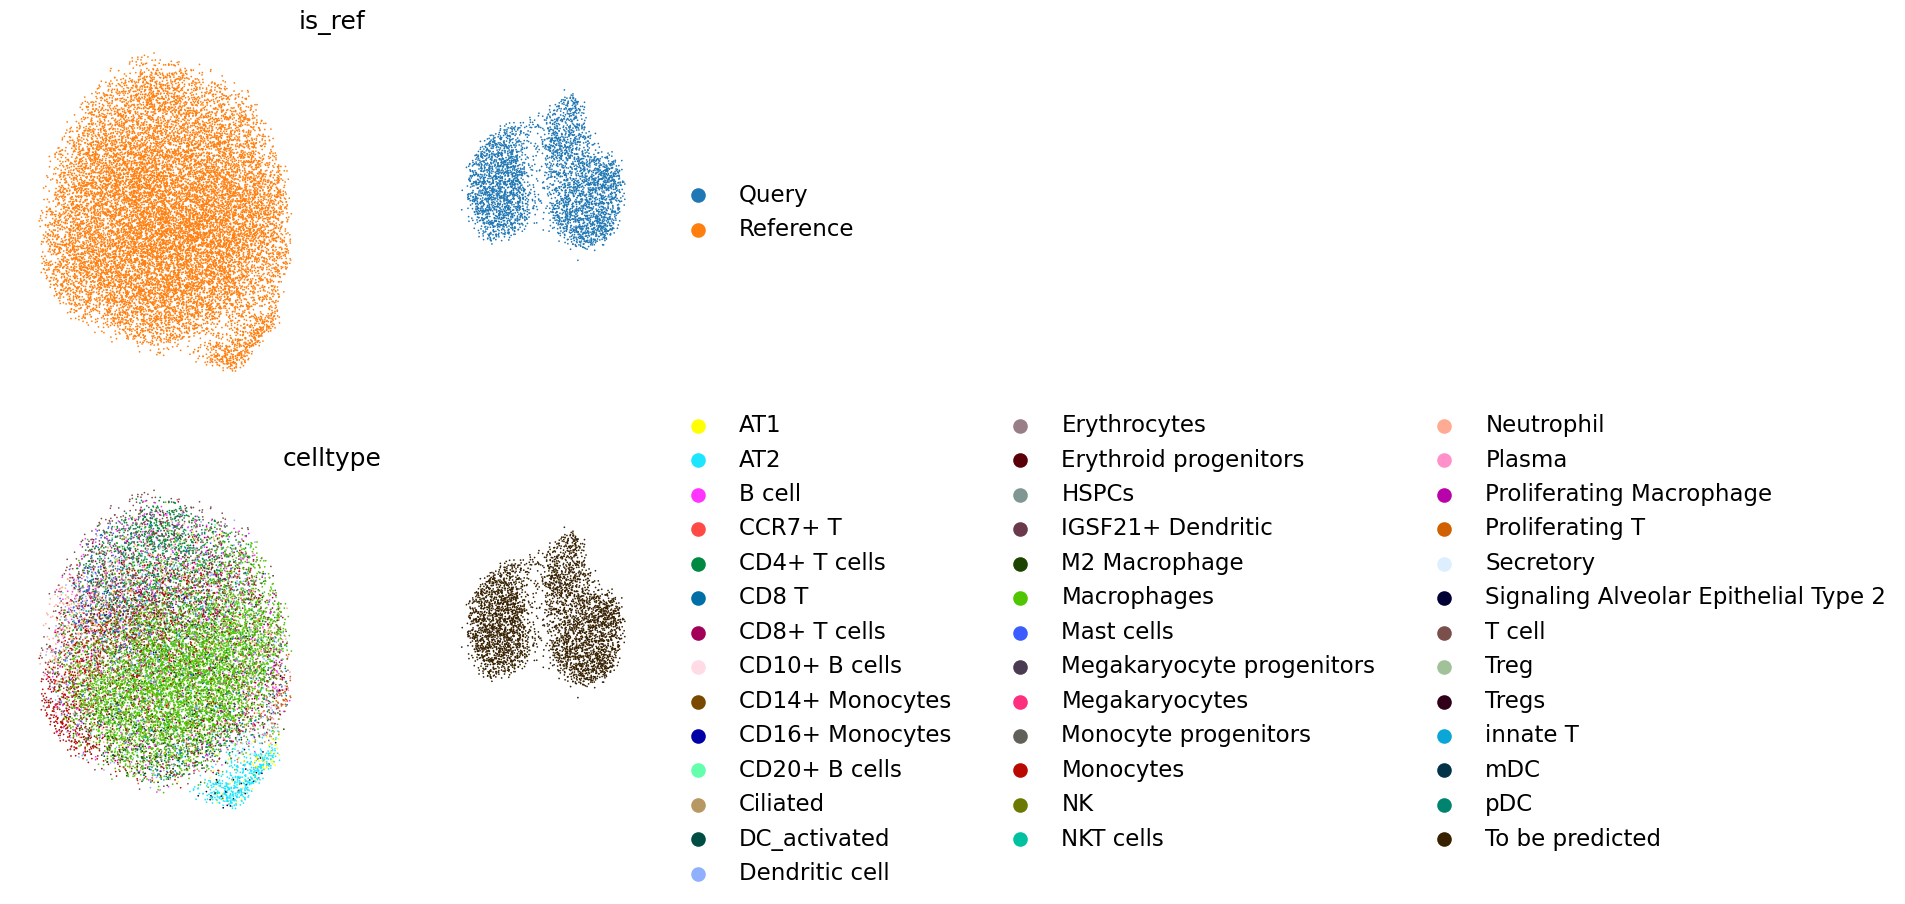

In [77]:
sc.pp.neighbors(adata_concat_rdModel, use_rep="X_scGPT")
sc.tl.umap(adata_concat_rdModel)
sc.pl.umap(
    adata_concat_rdModel, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

In [78]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [79]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
query_cell_embeddings = query_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbors


index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(query_cell_embeddings, k)

idx_list=[i for i in range(query_cell_embeddings.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(query_cell_embeddings[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = query_data.obs[cell_type_key].to_numpy()

/tmp/ipykernel_760742/3276322237.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/tmp/ipykernel_760742/3276322237.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
/tmp/ipykernel_760742/3276322237.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = ref_embed_adata.obs[cell_type_key][idx].value_c

In [80]:
from sklearn import metrics 
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s5srinivasan/py39env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'macro_f1': 0.0}

/tmp/ipykernel_760742/3308124233.py:5: RuntimeWarning: invalid value encountered in divide
  matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]


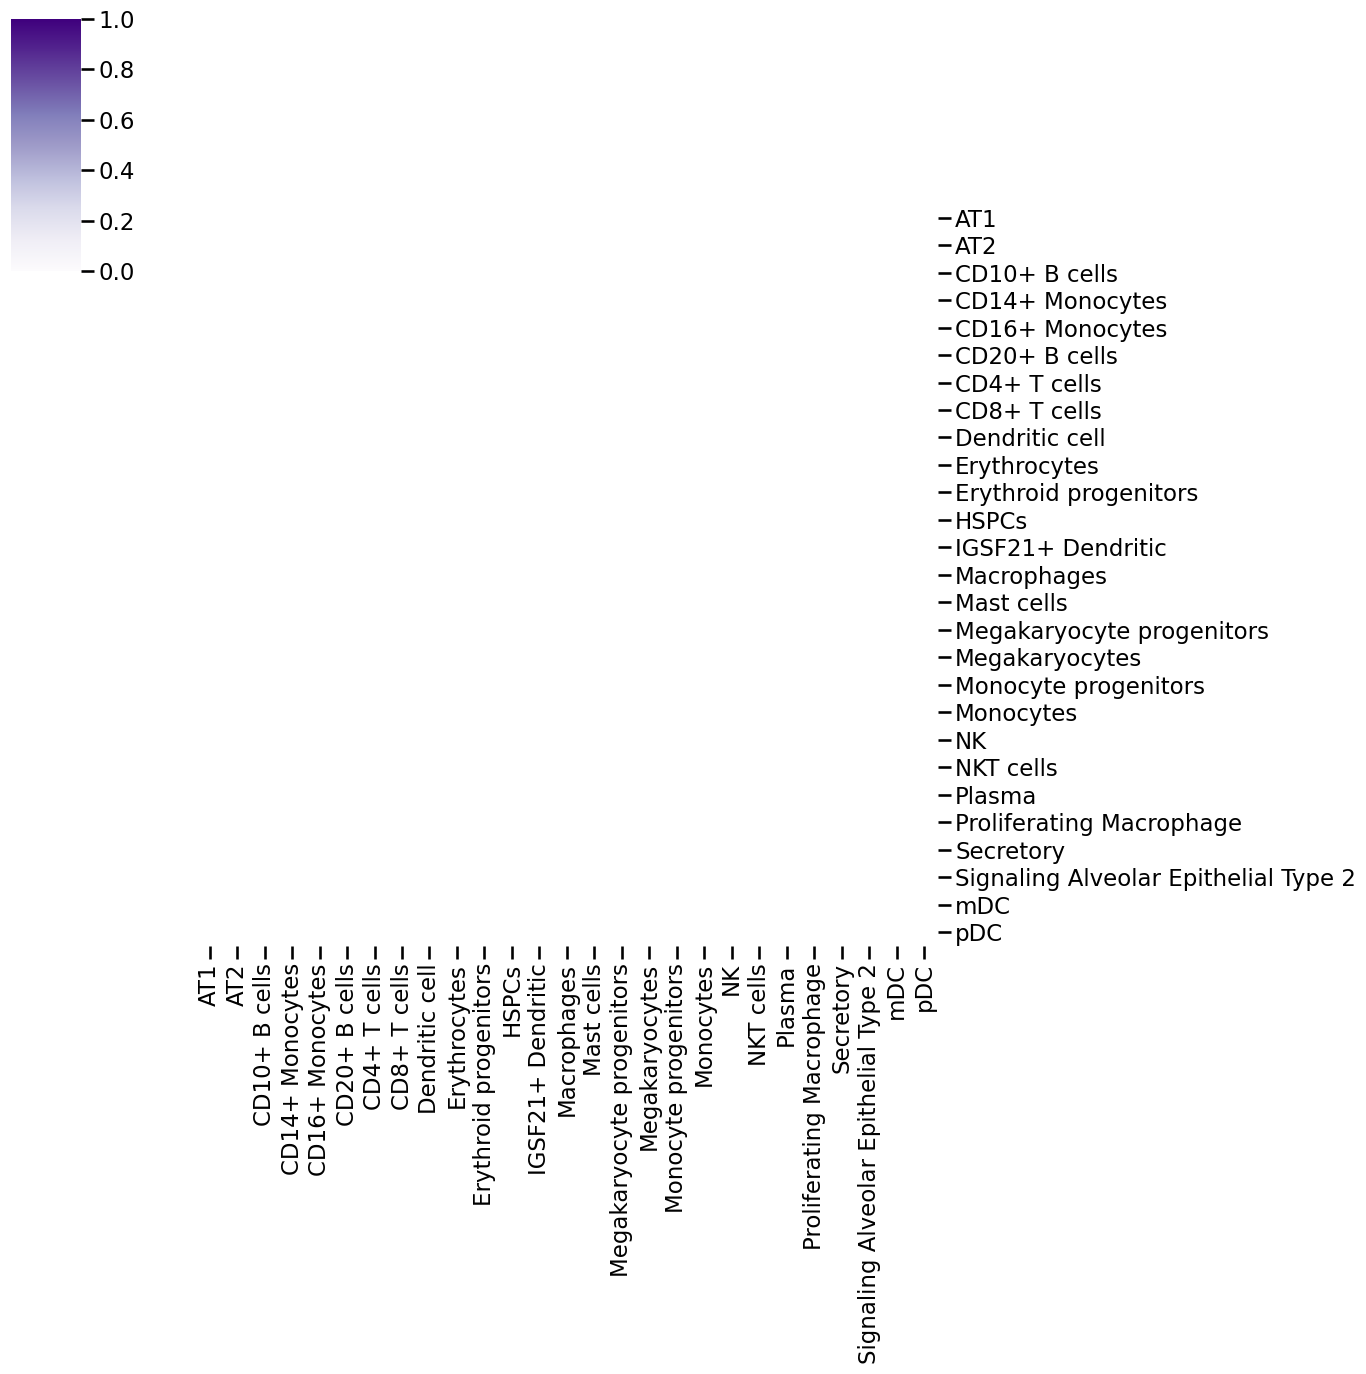

In [59]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))